# Save & Restore with Weights

* During optimization we save the variables of the neural network whenever its classification accuracy has improved on the validation-set. 
* The optimization is aborted when there has been no improvement for 1000 iterations. 
* We then reload the variables that performed best on the validation-set.
* This strategy is called Early Stopping. 
* It is used to avoid overfitting, which is not really a problem for the neural network used in this tutorial on the MNIST data-set for recognizing hand-written digits, but it demonstrates the idea.

## Flowchart

* The following set of images show (roughly) how the data flows in the Convolutional Neural Network implemented in this notebook. 
* This CNN has two convolutional layers and two fully-connected layers, with the last layer being used for the final classification of the input images.

<img src='../pics/mnist_weights.png'>

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time, math, os
from datetime import timedelta
import data # data helper functions

In [2]:
tf.__version__

'1.9.0'

## Load Data

#### Step 1: Read in data

In [3]:
batch_size=256
mnist_folder = '../data/mnist'
data.download_mnist(mnist_folder)
train, val, test = data.read_mnist(mnist_folder, flatten=False)
# Add validatation set into training as we don't need it for this example
new_train_images = np.concatenate([train[0],val[0]],axis=0)
new_train_labels = np.concatenate([train[1],val[1]],axis=0)
train = (new_train_images,new_train_labels)
del val

../data/mnist/train-images-idx3-ubyte.gz already exists
../data/mnist/train-labels-idx1-ubyte.gz already exists
../data/mnist/t10k-images-idx3-ubyte.gz already exists
../data/mnist/t10k-labels-idx1-ubyte.gz already exists


#### Step 2: Create datasets
* We have loaded the data as a tuple of numpy arrays
* We put the data into a `Dataset` object using the `from_tensor_slices` method
* We shuffle it, and then split it into batches, and also batch the test set

In [4]:
train_data = tf.data.Dataset.from_tensor_slices(train)
train_data = train_data.shuffle(10000) # if you want to shuffle your data
train_data = train_data.batch(batch_size)

test_data = tf.data.Dataset.from_tensor_slices(test)
test_data = test_data.batch(batch_size)

#### Step 3: Create iterator
* In this case, we are using `from_structure` and `make_initializer` to make our reinitializable iterator
* We reshape the image so that it is in the correct shape expected by TensorFlow's `tf.nn.conv2d` function

In [5]:
iterator = tf.data.Iterator.from_structure(train_data.output_types, 
                                       train_data.output_shapes)
next_img, next_label = iterator.get_next()

# reshape the image to make it work with tf.nn.conv2d
next_img = tf.reshape(next_img, shape=[-1, 28, 28, 1])

train_init = iterator.make_initializer(train_data)  # initializer for train_data
test_init = iterator.make_initializer(test_data)    # initializer for test_data

The MNIST data-set has now been loaded and consists of 70,000 images and associated labels (i.e. classifications of the images). The data-set is split into 3 mutually exclusive sub-sets. We will only use the training and test-sets in this tutorial.

In [6]:
print("Shape of:")
print("- Training-set:\t\t{}".format(train[0].shape))
print("- Test-set:\t\t{}".format(test[0].shape))
print("- Training-labels:\t\t{}".format(train[1].shape))
print("- Test-set-labels:\t\t{}".format(test[1].shape))

Shape of:
- Training-set:		(60000, 28, 28)
- Test-set:		(10000, 28, 28)
- Training-labels:		(60000, 10)
- Test-set-labels:		(10000, 10)


The class-labels are One-Hot encoded, which means that each label is a vector with 10 elements, all of which are zero except for one element. The index of this one element is the class-number, that is, the digit shown in the associated image. We also need the class-numbers as integers for the test- and validation-sets, so we calculate them now.

In [7]:
class_numbers = np.argmax(test[1], axis=1)

## Data Dimensions

The data dimensions are used in several places in the source-code below. They are defined once so we can use these variables instead of numbers throughout the source-code below.

In [8]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

### Helper-function for plotting images

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [9]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3,figsize=(6,6))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes. 
        # We convert from one-hot to integer labels using np.argmax
        if cls_pred is None:
            xlabel = "True: {0}".format(np.argmax(cls_true[i]))
        else:
            xlabel = "True: {0}, Pred: {1}".format(np.argmax(cls_true[i]), cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Plot a few images to see if data is correct

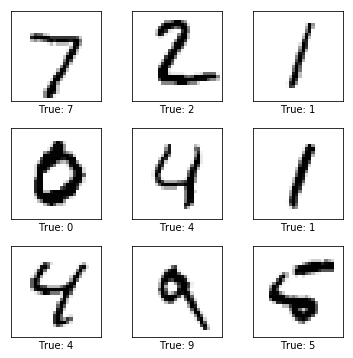

In [10]:
# Get the first images from the test-set.
images = test[0][0:9]

# Get the true classes for those images.
cls_true = test[1][0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

### Placeholder variables

Placeholder variables serve as the input to the TensorFlow computational graph that we may change each time we execute the graph. We call this feeding the placeholder variables and it is demonstrated further below.

First we define the placeholder variable for the input images. This allows us to change the images that are input to the TensorFlow graph. This is a so-called tensor, which just means that it is a multi-dimensional array. The data-type is set to `float32` and the shape is set to `[None, img_size_flat]`, where `None` means that the tensor may hold an arbitrary number of images with each image being a vector of length `img_size_flat`.

In [11]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

The convolutional layers expect `x` to be encoded as a 4-dim tensor so we have to reshape it so its shape is instead `[num_images, img_height, img_width, num_channels]`. Note that `img_height == img_width == img_size` and `num_images` can be inferred automatically by using -1 for the size of the first dimension. So the reshape operation is:

In [12]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable `x`. The shape of this placeholder variable is `[None, num_classes]` which means it may hold an arbitrary number of labels and each label is a vector of length `num_classes` which is 10 in this case.

In [13]:
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')

We could also have a placeholder variable for the class-number, but we will instead calculate it using argmax. Note that this is a TensorFlow operator so nothing is calculated at this point.

In [14]:
y_true_cls = tf.argmax(y_true, axis=1)

### Neural Network
* First we create a series of functions to manage the main operations of our neural network

In [15]:
def conv_activ(inputs, filters, k_size, stride, padding='VALID', scope_name='conv', activation=tf.nn.relu):
    '''
    A method that does convolution + an activation function on inputs
    '''
    with tf.variable_scope(scope_name, reuse=tf.AUTO_REUSE) as scope:
        in_channels = inputs.shape[-1]
        kernel = tf.get_variable('kernel', 
                                [k_size, k_size, in_channels, filters], 
                                initializer=tf.truncated_normal_initializer())
        biases = tf.get_variable('biases', 
                                [filters],
                                initializer=tf.random_normal_initializer())
        conv = tf.nn.conv2d(inputs, kernel, strides=[1, stride, stride, 1], padding=padding)
    return activation(conv + biases, name=scope.name)

def maxpool(inputs, ksize, stride, padding='VALID', scope_name='pool'):
    '''A method that does max pooling on inputs'''
    with tf.variable_scope(scope_name, reuse=tf.AUTO_REUSE) as scope:
        pool = tf.nn.max_pool(inputs, 
                            ksize=[1, ksize, ksize, 1], 
                            strides=[1, stride, stride, 1],
                            padding=padding)
    return pool

def fully_connected(inputs, out_dim, scope_name='fc'):
    '''
    A fully connected linear layer on inputs
    '''
    with tf.variable_scope(scope_name, reuse=tf.AUTO_REUSE) as scope:
        in_dim = inputs.shape[-1]
        w = tf.get_variable('weights', [in_dim, out_dim],
                            initializer=tf.truncated_normal_initializer())
        b = tf.get_variable('biases', [out_dim],
                            initializer=tf.constant_initializer(0.0))
        out = tf.matmul(inputs, w) + b
    return out

def flatten_layer(inputs):
    feature_dim = inputs.shape[1] * inputs.shape[2] * inputs.shape[3]
    return tf.reshape(inputs, [-1, feature_dim])

### Create the computational graph for our Convolutional Network architecture using our pre-defined layer functions
* Here we are simply feeding the output of the previous layer function into the next layer function in a sequential fashion

In [16]:
n_classes=10
conv1 = conv_activ(inputs=next_img,filters=16,k_size=5,stride=1,scope_name='conv1')
pool1 = maxpool(conv1, ksize=2, stride=2, padding='VALID',scope_name='pool1')
conv2 = conv_activ(inputs=pool1,filters=36, k_size=2, stride=1,scope_name='conv2')
pool2 = maxpool(conv2, ksize=2, stride=2, padding='VALID', scope_name='pool2')
flattened = flatten_layer(pool2)
fc = fully_connected(flattened, out_dim=1024, scope_name='fc')
dropout = tf.nn.dropout(tf.nn.relu(fc), keep_prob=0.5, name='relu_dropout')
logits = fully_connected(dropout, out_dim=n_classes, scope_name='logits')
y_pred = tf.nn.softmax(logits)

### Getting the Weights

Further below, we want to plot the weights of the neural network. When the network is constructed using Pretty Tensor, all the variables of the layers are created indirectly by Pretty Tensor. We therefore have to retrieve the variables from TensorFlow.

We used the names `conv1` and `conv2` for the two convolutional layers. These are also called variable scopes.

In [17]:
# Display layers
layers = {v.op.name: v for v in tf.trainable_variables()}
layers

{'conv1/biases': <tf.Variable 'conv1/biases:0' shape=(16,) dtype=float32_ref>,
 'conv1/kernel': <tf.Variable 'conv1/kernel:0' shape=(5, 5, 1, 16) dtype=float32_ref>,
 'conv2/biases': <tf.Variable 'conv2/biases:0' shape=(36,) dtype=float32_ref>,
 'conv2/kernel': <tf.Variable 'conv2/kernel:0' shape=(2, 2, 16, 36) dtype=float32_ref>,
 'fc/biases': <tf.Variable 'fc/biases:0' shape=(1024,) dtype=float32_ref>,
 'fc/weights': <tf.Variable 'fc/weights:0' shape=(900, 1024) dtype=float32_ref>,
 'logits/biases': <tf.Variable 'logits/biases:0' shape=(10,) dtype=float32_ref>,
 'logits/weights': <tf.Variable 'logits/weights:0' shape=(1024, 10) dtype=float32_ref>}

In [18]:
with tf.variable_scope('conv1', reuse=tf.AUTO_REUSE):
    weights = tf.get_variable('kernel')
    print(weights)    

<tf.Variable 'conv1/kernel:0' shape=(5, 5, 1, 16) dtype=float32_ref>


The implementation is somewhat awkward because we have to use the TensorFlow function `get_variable()` which was designed for another purpose; either creating a new variable or re-using an existing variable. The easiest thing is to make the following helper-function.

In [19]:
def get_weights_variable(layer_name):
    # Retrieve an existing variable named 'kernel' in the scope with the given layer_name.
    # This is awkward because the TensorFlow function was really intended for another purpose.
    with tf.variable_scope(layer_name, reuse=tf.AUTO_REUSE):
        variable = tf.get_variable('kernel')
    return variable

Using this helper-function we can retrieve the variables. These are TensorFlow objects. In order to get the contents of the variables, you must do something like: `contents = session.run(weights_conv1)` as demonstrated further below.

In [20]:
weights_conv1 = get_weights_variable(layer_name='conv1')
weights_conv2 = get_weights_variable(layer_name='conv2')

### Loss

In [21]:
with tf.name_scope('loss'):
    entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=next_label, logits=logits)
    loss = tf.reduce_mean(entropy, name='loss')

### Optimization Method

We have the predicted class-label (`y_pred`) as well as a loss-measure that must be minimized, so as to improve the ability of the neural network to classify the input images.

Note that optimization is not performed at this point. In fact, nothing is calculated at all, we just add the optimizer-object to the TensorFlow graph for later execution.

In [22]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

### Performance Measures

We need a few more performance measures to display the progress to the user.

First we calculate the predicted class number from the output of the neural network `y_pred`, which is a vector with 10 elements. The class number is the index of the largest element.

In [23]:
y_pred_cls = tf.argmax(y_pred, axis=1)

Then we create a vector of booleans telling us whether the predicted class equals the true class of each image.

In [24]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

The classification accuracy is calculated by first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then taking the average of these numbers.

In [25]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Saver

In order to save the variables of the neural network, we now create a so-called Saver-object which is used for storing and retrieving all the variables of the TensorFlow graph. Nothing is actually saved at this point, which will be done further below in the `optimize()`-function.

In [26]:
saver = tf.train.Saver()

The saved files are often called checkpoints because they may be written at regular intervals during optimization.

This is the directory used for saving and retrieving the data.

In [27]:
save_dir = 'checkpoints/'

Create the directory if it does not exist.

In [28]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

This is the path for the checkpoint-file.

In [29]:
save_path = os.path.join(save_dir, 'best_validation')

## TensorFlow Run

* Just this time, we're going to create a TensorFlow session and leave it open for the duration of this notebook
* Normally, you should not do this, and instead encapsulate the session run in the training loop as illustrated in the other notebooks

In [30]:
sess = tf.Session()

In [31]:
# we also define a helper function to initialize variables
def init_variables():
    sess.run(tf.global_variables_initializer())

### Helper-function to perform optimization iterations

There are 55,000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore only use a small batch of images in each iteration of the optimizer.

If your computer crashes or becomes very slow because you run out of RAM, then you may try and lower this number, but you may then need to perform more optimization iterations.

In [32]:
train_batch_size = 64

The classification accuracy for the validation-set will be calculated for every 100 iterations of the optimization function below. The optimization will be stopped if the validation accuracy has not been improved in 1000 iterations. We need a few variables to keep track of this.

In [33]:
# Best validation accuracy seen so far.
best_validation_accuracy = 0.0

# Iteration-number for last improvement to validation accuracy.
last_improvement = 0

# Stop optimization if no improvement found in this many iterations.
require_improvement = 1000

### Accuracy Calculations

In [34]:
with tf.name_scope('predict'):
    preds = tf.nn.softmax(logits)
    correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(next_label, 1))
    accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32))

### Evaluation

In [35]:
def eval_once(sess, init, writer=None, epoch=0, step=None):
    global training
    n_test=10000
    start_time = time.time()
    sess.run(init)
    training = False
    total_correct_preds = 0
    try:
        while True:
            accuracy_batch, summaries = sess.run([accuracy, summary_op])
            if writer:
                writer.add_summary(summaries, global_step=step)
            total_correct_preds += accuracy_batch
    except tf.errors.OutOfRangeError:
        pass
    
    # 
    print('Accuracy at epoch {0}: {1} '.format(epoch, total_correct_preds/n_test))
    print('Took: {0} seconds'.format(time.time() - start_time))
    

### Summaries for TensorBoard

In [36]:
with tf.name_scope('summaries'):
    tf.summary.scalar('loss', loss)
    tf.summary.scalar('accuracy', accuracy)
    tf.summary.histogram('histogram_loss', loss)
    summary_op = tf.summary.merge_all()

### Our training function

In [37]:
def train_one_epoch(sess, saver, init, writer, epoch, step, skip_step=1):
    global training
    start_time = time.time()
    sess.run(init) 
    training = True
    total_loss = 0
    n_batches = 0
    try:
        while True:
            _, l, summaries = sess.run([optimizer, loss, summary_op])
            writer.add_summary(summaries, global_step=step)
            if step % skip_step == 0:
                print('Loss at step {0}: {1}'.format(step, l))
            step += 1
            total_loss += l
            n_batches += 1
    except tf.errors.OutOfRangeError:
        pass
    saver.save(sess, 'checkpoints/convnet_mnist/mnist-convnet', step)
    print('Average loss at epoch {0}: {1}'.format(epoch, total_loss/n_batches))
    print('Took: {0} seconds'.format(time.time() - start_time))
    return step

Function for performing a number of optimization iterations so as to gradually improve the variables of the network layers. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples.  The progress is printed every 100 iterations where the validation accuracy is also calculated and saved to a file if it is an improvement.

In [38]:
# Set up a global step counter
gstep = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')

In [39]:
def train_network(n_epochs=20,skip_step=100,restore=False,lr=1e-4,eval_init=test_init):
    '''
    The train function alternates between training one epoch and evaluating
    '''
    data.safe_mkdir('checkpoints')
    data.safe_mkdir('checkpoints/convnet_mnist')
    writer = tf.summary.FileWriter('./graphs/convnet', tf.get_default_graph())

    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/convnet_mnist/checkpoint'))
    if restore and ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)
        optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)

    step = gstep.eval(session=sess)

    for epoch in range(n_epochs):
        step = train_one_epoch(sess, saver, train_init, writer, epoch, step, skip_step)
        eval_once(sess, eval_init, writer, epoch, step)
    writer.close()

In [40]:
train_network(n_epochs=10, skip_step=1000, restore=False, lr=1e-4, eval_init=test_init)

Loss at step 0: 14195.6943359375
Average loss at epoch 0: 8093.8193338597075
Took: 3.29201340675354 seconds
Accuracy at epoch 0: 0.2356 
Took: 0.3178446292877197 seconds
Average loss at epoch 1: 4145.188539935173
Took: 1.5674607753753662 seconds
Accuracy at epoch 1: 0.4008 
Took: 0.09257626533508301 seconds
Average loss at epoch 2: 2481.7674207322143
Took: 1.5850651264190674 seconds
Accuracy at epoch 2: 0.5406 
Took: 0.09958863258361816 seconds
Average loss at epoch 3: 1634.4114683759974
Took: 1.5619940757751465 seconds
Accuracy at epoch 3: 0.6352 
Took: 0.09436297416687012 seconds
Loss at step 1000: 1307.5313720703125
Average loss at epoch 4: 1172.873527883976
Took: 1.5725932121276855 seconds
Accuracy at epoch 4: 0.6908 
Took: 0.08532309532165527 seconds
Average loss at epoch 5: 892.0242977061171
Took: 1.570378065109253 seconds
Accuracy at epoch 5: 0.7359 
Took: 0.0987699031829834 seconds
Average loss at epoch 6: 705.5035489995429
Took: 1.5529272556304932 seconds
Accuracy at epoch 6: 

In [41]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variables rather than local copies.
    global total_iterations
    global best_validation_accuracy
    global last_improvement

    # Start-time used for printing time-usage below.
    start_time = time.time()
    sess.run(train_init)
    
    for i in range(num_iterations):

        # Increase the total number of iterations performed.
        # It is easier to update it in each iteration because
        # we need this number several times in the following.
        total_iterations += 1

        try:
            sess.run([loss,optimizer])
        except tf.errors.OutOfRangeError or ValueError:
            pass
        
        # Print status every 100 iterations and after last iteration.
        if (total_iterations % 100 == 0) or (i == (num_iterations - 1)):

            # Calculate the accuracy on the training-batch.
            #acc_train = session.run(accuracy, feed_dict=feed_dict_train)
            try:
                acc_train = sess.run(accuracy)
            except tf.errors.OutOfRangeError:
                pass

            # Calculate the accuracy on the validation-set.
            # The function returns 2 values but we only need the first.
            acc_validation, _ = validation_accuracy()

            # If validation accuracy is an improvement over best-known.
            if acc_validation > best_validation_accuracy:
                # Update the best-known validation accuracy.
                best_validation_accuracy = acc_validation
                
                # Set the iteration for the last improvement to current.
                last_improvement = total_iterations

                # Save all variables of the TensorFlow graph to file.
                saver.save(sess=sess, save_path=save_path)

                # A string to be printed below, shows improvement found.
                improved_str = '*'
            else:
                # An empty string to be printed below.
                # Shows that no improvement was found.
                improved_str = ''
            
            # Status-message for printing.
            msg = "Iter: {0:>6}, Train-Batch Accuracy: {1:>6.1%}, Validation Acc: {2:>6.1%} {3}"

            # Print it.
            print(msg.format(i + 1, acc_train, acc_validation, improved_str))

        # If no improvement found in the required number of iterations.
        if total_iterations - last_improvement > require_improvement:
            print("No improvement found in a while, stopping optimization.")

            # Break out from the for-loop.
            break

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### Helper-function for plotting convolutional weights

In [42]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.

    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = sess.run(weights)

    # Print mean and standard deviation.
    print("Mean: {0:.5f}, Stdev: {1:.5f}".format(w.mean(), w.std()))
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # The format of this 4-dim tensor is determined by the
            # TensorFlow API. See Tutorial #02 for more details.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Show convolution weights

In [43]:
eval_once(sess, test_init, writer=None, epoch=99999999999, step=None)

Accuracy at epoch 99999999999: 0.9391 
Took: 0.08668327331542969 seconds


Mean: 0.01481, Stdev: 0.83997


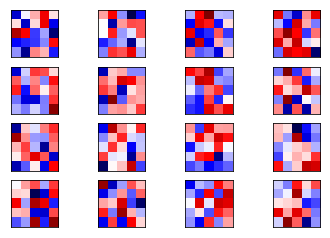

In [44]:
plot_conv_weights(weights=weights_conv1)

### Close the Graph Session
* We need to remember to do this to get TensorFlow to release system resources

In [45]:
sess.close()
print("Done")

Done
